# Customer Segmentation Report

In [1]:
%matplotlib inline
import pickle
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import Data

In [2]:
# load the local dataset 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank_customers_churn_dataset.csv',
        index_col='customer_id'
)

# drop churn column for segmentation
df.drop('churn', axis=1, inplace=True)

# change type of categorical columns "credit_card" and "active_member"
df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,yes,yes,101348.88
15647311,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58
15619304,502,France,Female,42,8,159660.80,3,yes,no,113931.57
15701354,699,France,Female,39,1,0.00,2,no,no,93826.63
15737888,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10


# Load Model Artifacts

In [3]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/categorical_imputer.pickle', 'rb') as filename: # trained model to impute missing categorical data
    categorical_imputer = pickle.load(filename) 

with open('../artifacts/rare_encoder.pickle', 'rb') as filename: # trained model to encode rare labels
    rare_encoder = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/enc.pickle', 'rb') as filename: # trained one hot encoder
    enc = pickle.load(filename)

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [4]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()
categorical_columns = df.select_dtypes(exclude=numerics).columns.to_list()

In [5]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# impute mising categorical features
df_categorical = pd.DataFrame(
    categorical_imputer.transform(df[categorical_columns]), 
    columns=categorical_columns, 
    index=df.index)

# concate numeric and categorical features
df = pd.concat([df_numeric, df_categorical], axis=1)

# remove rare labels
df[categorical_columns] = rare_encoder.transform(df[categorical_columns])

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# one hot encoding categorical features
df_cat_hotenc = pd.DataFrame(
    enc.transform(df[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=df.index) 

# concate numeric and hot-encoded categorical features
df_hotenc = pd.concat([df[numeric_columns], df_cat_hotenc], axis=1)

# predict cluster
labels = model.predict(df_hotenc)

# add cluster label to df
df['cluster'] = labels

df.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member,cluster
customer_id,,,,,,,,,,,
15634602,619.0,42.0,2.0,0.00,1.0,101348.88,France,Female,yes,yes,1
15647311,608.0,41.0,1.0,83807.86,1.0,112542.58,Spain,Female,no,yes,0
15619304,502.0,42.0,8.0,159660.80,3.0,113931.57,France,Female,yes,no,3
15701354,699.0,39.0,1.0,0.00,2.0,93826.63,France,Female,no,no,3
15737888,850.0,43.0,2.0,125510.82,1.0,79084.10,Spain,Female,yes,yes,1


# Data Visualization

In [6]:
# Cluster Counts
df['cluster'].value_counts()

1    2734
3    2423
5    1261
2    1248
0    1169
4    1165
Name: cluster, dtype: int64

## What does the Cluster Distribution Lool Like?

In [7]:
# Cluster Counts
cluster_labels = []
for c in df['cluster'].value_counts().index.tolist():
    label = 'Cluster ' + str(c)
    cluster_labels.append(label)
cluster_labels

['Cluster 1', 'Cluster 3', 'Cluster 5', 'Cluster 2', 'Cluster 0', 'Cluster 4']

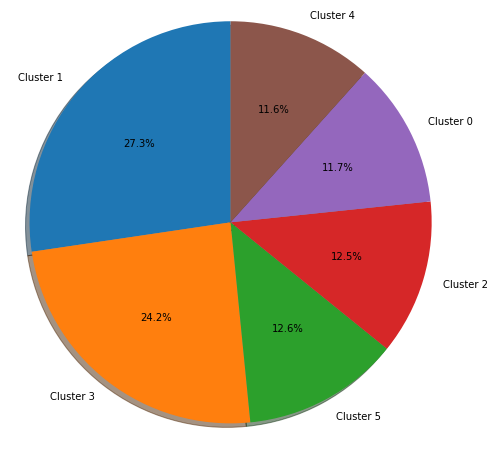

In [8]:
labels = cluster_labels
sizes = df['cluster'].value_counts().to_list()
explode = tuple(0 for _ in range(len(cluster_labels)))  

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    x=sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Determine Cluster Centers

In [9]:
# Cluster Centers
pd.concat([
    df.groupby(by='cluster').mean(),
    df.groupby(by='cluster').aggregate(pd.Series.mode)[categorical_columns] ],
    axis=1)


['estimated_salary'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
cluster,,,,,,,,,,
0,651.337896,39.947621,4.796407,64975.713370,1.529737,101585.407280,France,Male,no,yes
1,652.849305,39.484752,5.032919,60451.419214,1.528936,98028.231372,France,Male,yes,yes
2,654.615385,39.920666,4.842949,119874.607700,1.539126,100576.684006,Germany,Male,yes,yes
3,646.894759,37.340945,5.054065,63463.576232,1.513989,100982.054408,France,Male,yes,no
4,649.837768,37.677730,5.103004,59616.306635,1.567738,99370.597966,Spain,Male,yes,no
5,648.324346,39.522335,5.175258,119587.114171,1.486884,101644.652680,Germany,Female,yes,no


# Explain Clusters

In [10]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    output = 'probability')

# get random sample
X = df_hotenc.sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

# Custom Functions

In [11]:
def get_top_cluster_features(shap_values, cluster=0, topn=5):
    """Get top n features for given cluster"""
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()
    return topn_features

def plot_cluster_feature_importance(shap_values, cluster=0, topn=5):
    """Barplot feature importance for specific cluster"""
    fig = plt.figure(figsize=(10,6))
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()

    # get most important top n
    plt.barh(
        width=shap_values_df_topn, 
        y=shap_values_df_topn.index
    )
    plt.title('Feature Importance for Cluster {}'.format(cluster))
    plt.xlabel('mean(|shap value|)')
    #plt.xlim(-.5,.5)
    plt.show()

def plot_cluster_shap_values(shap_values, cluster=0, topn=5):
    """Violin plot of the shap values for cluster"""
    shap.summary_plot(
        shap_values = shap_values[cluster], 
        features = X,
        sort=True,
        plot_size=(12.0,6.0),
        show=False,
        max_display=topn,
        plot_type='violin'
        )
    ax=plt.gca()
    ax.set_title('Shap Feature Importance for Cluster {}'.format(cluster))
    ax.grid()
    ax.set_xlim(-.5,.5)
    fig = plt.gcf()
    plt.show()

def jitter(values, loc, scale):
    """Add some jitter for visibility"""
    return values + np.random.normal(loc, scale,values.shape)

## Average Feature Importance on Cluster Building

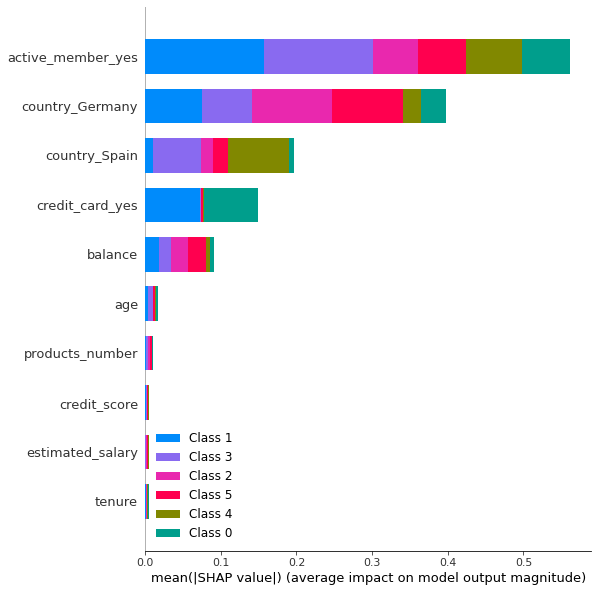

In [12]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    max_display=10,
    plot_size=(8.0,10.0)
)

## Explain Single Cluster vs Rest

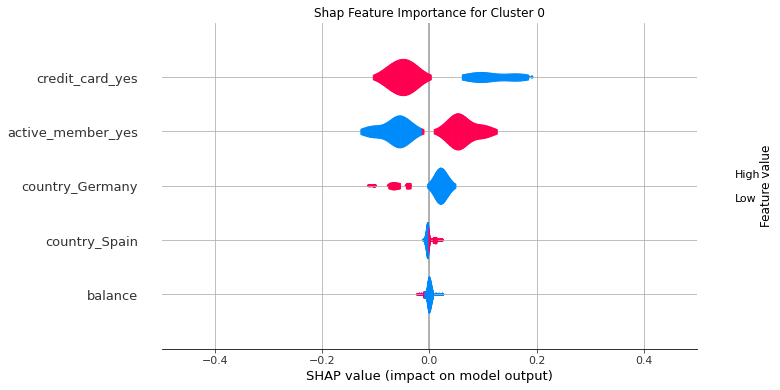

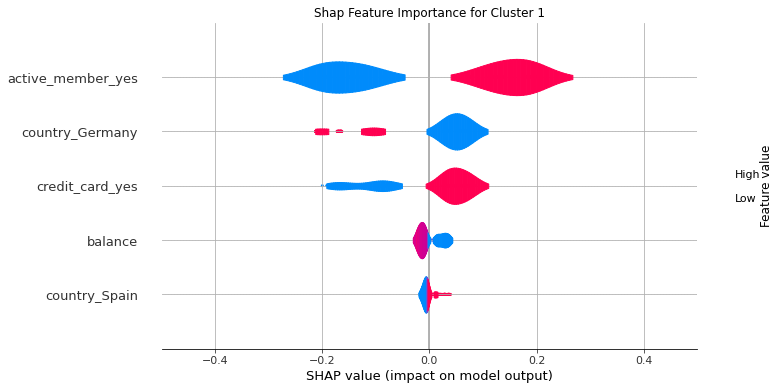

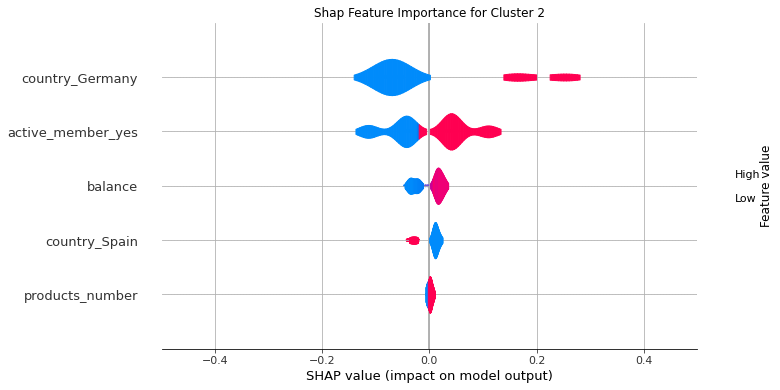

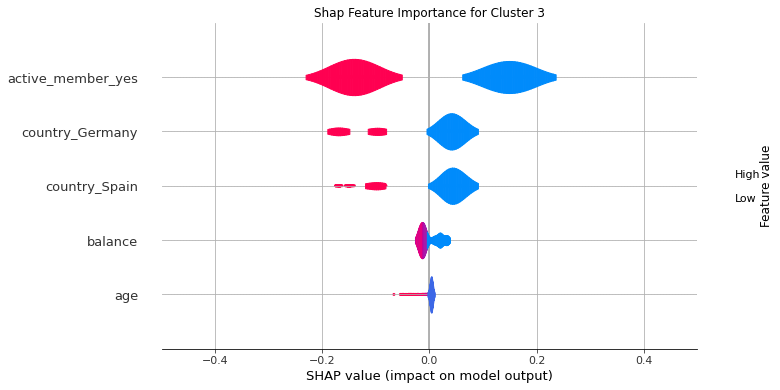

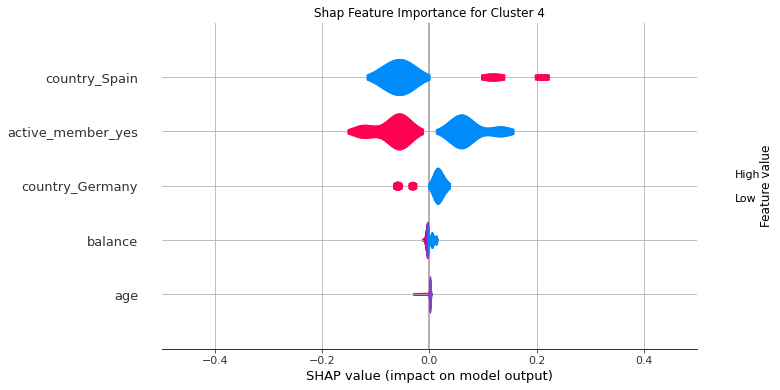

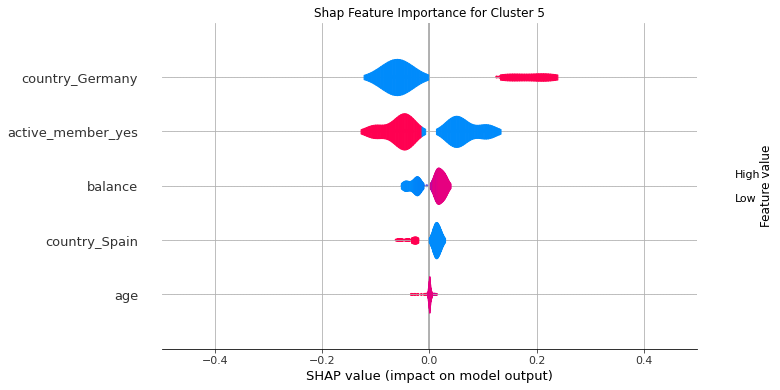

In [13]:
for c in np.sort(df['cluster'].unique()):
    #plot_cluster_feature_importance(
    #    shap_values, 
    #    cluster=c, 
    #    topn=5)
    
    plot_cluster_shap_values(
        shap_values, 
        cluster=c, 
        topn=5)

In [14]:
# get top n features in cluster n
get_top_cluster_features(
    shap_values, 
    cluster=2, 
    topn=5)

['country_Germany',
 'active_member_yes',
 'balance',
 'country_Spain',
 'products_number']

In [15]:
# get most important features considering the top n features in each cluster
n=5
array = [get_top_cluster_features(shap_values, cluster=c, topn=n) for c in np.sort(df['cluster'].unique())]
top_features = list(set(chain(*array)))
top_features

['credit_card_yes',
 'age',
 'products_number',
 'active_member_yes',
 'balance',
 'country_Germany',
 'country_Spain']

In [16]:
# seperate top_features into numerical and categorical features
top_features_num = [feat for feat in top_features if feat not in df_cat_hotenc.columns]
top_features_num

['age', 'products_number', 'balance']

In [17]:
top_features_cat = list(set([feat.rsplit('_',1)[0] for feat in top_features if feat in df_cat_hotenc.columns]))
top_features_cat

['credit_card', 'active_member', 'country']

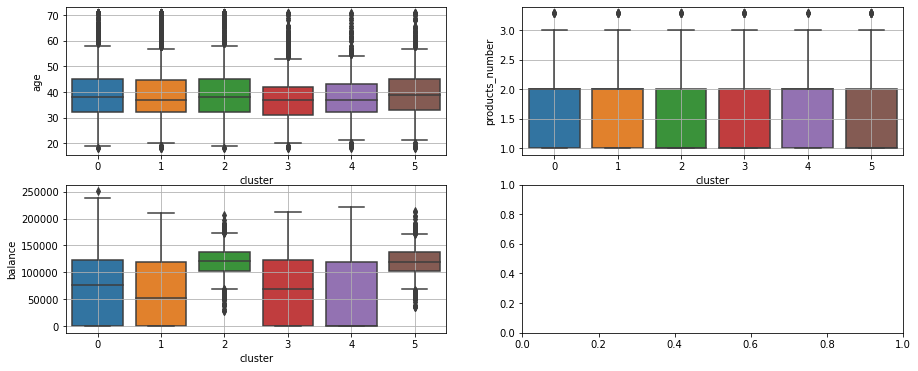

In [19]:
# boxplots for numeric columns
fig, ax = plt.subplots(
        figsize=(15,6), 
        nrows=2, 
        ncols=2, 
        #sharex=True
        )
ax = ax.flatten()


for n, feat in enumerate(top_features_num):
    sns.boxplot(
        data=df,
        x='cluster',
        y=feat,
        whis=1.0,
        ax=ax[n]
    )
    ax[n].grid()
plt.show()

In [20]:
# show number of unique combinations for scatter plotting
len([c for c in itertools.combinations(top_features_num, 2)])

3

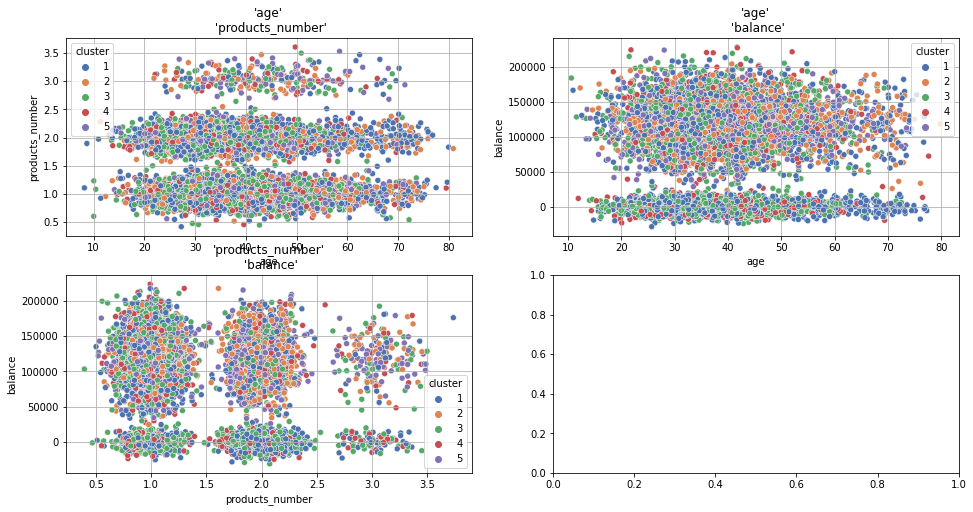

In [22]:
# exclude noise for visibility
data = df[df['cluster']!=0]
#size=[1 if c == 0 else 2 for c in df['cluster']]

fig, ax = plt.subplots(
        figsize=(16,8), 
        nrows=2, 
        ncols=2, 
        #sharex=True
        )
ax = ax.flatten()

for n, c in enumerate(itertools.combinations(top_features_num, 2)):
    x = data[c[0]]
    x_mean = np.mean(x)
    y = data[c[1]]
    y_mean = np.mean(y)

    sns.scatterplot(
        data=data,
        x=jitter(x, 0, 0.1*x_mean),
        y=jitter(y, 0, 0.1*y_mean),
        hue='cluster',
        #hue_order=(1,2,0),
        palette='deep',
        #alpha=.5,
        #size=size,
        ax=ax[n]
    )
    title = str(c).strip('(,)').split(',')
    ax[n].set_title(title[0]+'\n'+title[1])
    ax[n].grid()

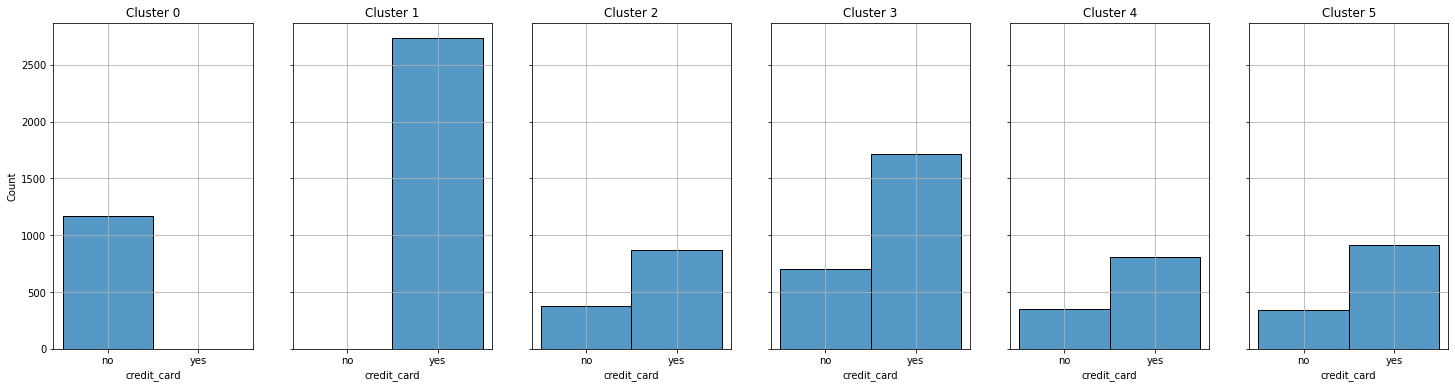

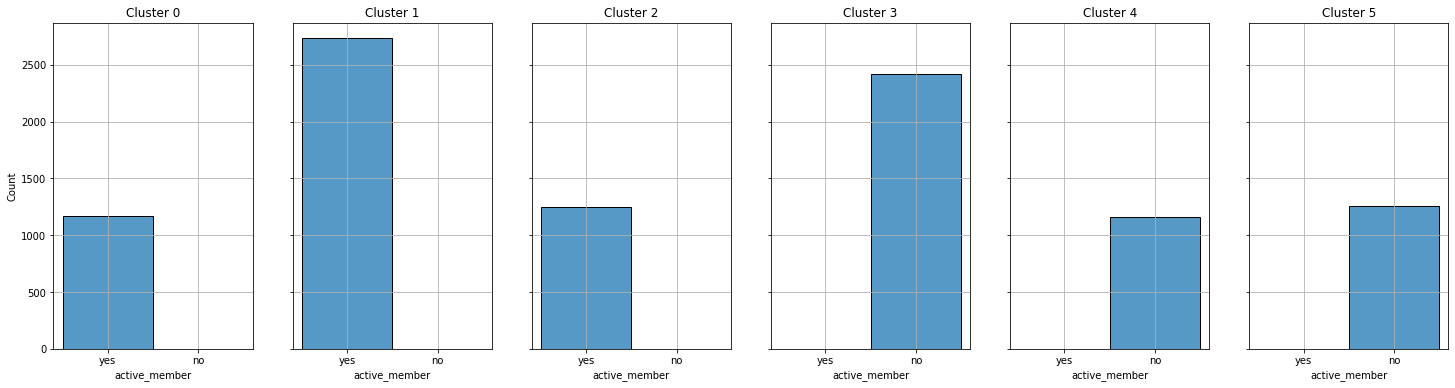

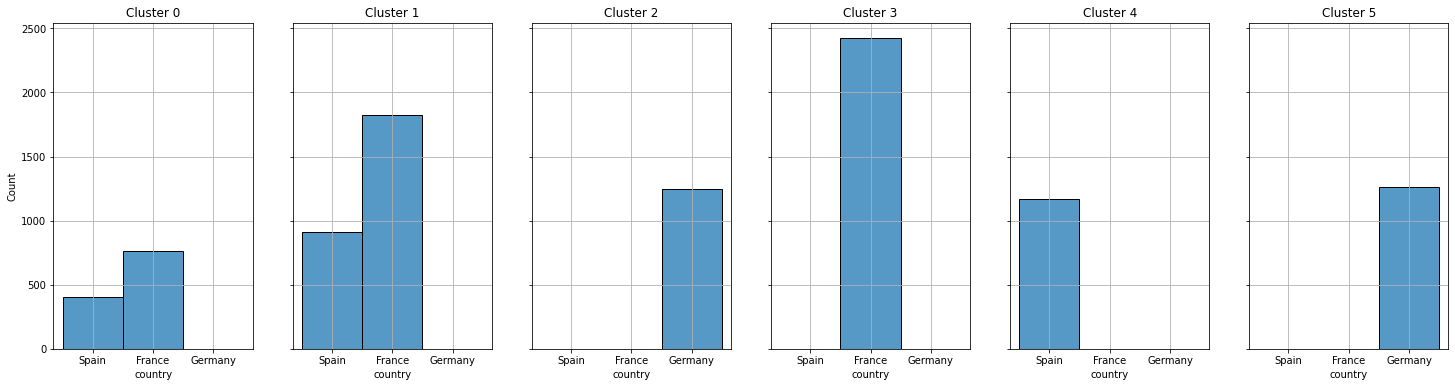

In [25]:
# visualize categorical features for each cluster
for feat in top_features_cat:

    fig, ax = plt.subplots(
        figsize=(25,6), 
        nrows=1, 
        ncols=df['cluster'].nunique(), 
        sharex=True,
        sharey=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            ax=ax[c])    
        #ax[c].set_xticks(ax[c].get_xticks(), df[feat].unique(), rotation=90)
        ax[c].set_title('Cluster '+str(c))
        ax[c].grid()
    plt.show()

In [26]:
# Export Notebook as PDF
!jupyter nbconvert 12_customer_seg_bankchurndata_report.ipynb --output-dir='../reports' --to pdf --no-input --output Customer_Segmentation_Report.pdf

C:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\traitlets\traitlets.py:2389: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '../reports' instead of "'../reports'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook 12_customer_seg_bankchurndata_report.ipynb to pdf
[NbConvertApp] Support files will be in Customer_Segmentation_Report_files\
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Making directory .\Customer_Segmentation_Report_files
[NbConvertApp] Mak